# Economics of Security - Rien, Rob & Patrick
## Block 2 - Metrics evaluation
    1. Loading and pre-processing the dataset
    2. Evaluating the five metrics
        1a. Requests of top-10000 malicious devices per ISP over time (daily)
        1b. Unique top-10000 malicious devices per ISP over time (daily)
        2a. Total requests per country over time (daily)
        2b. Total unique malicious devices per country over time (daily)
        3. Attack strategy distribution of top-10000 malicious devices per ISP over time (daily)

In [65]:
# We first need to import some libraries
from scipy.stats.stats import pearsonr
from scipy.spatial.distance import mahalanobis
import os, re, csv, math
import datetime, time
import pandas as pd
import numpy as np
import requests, ipaddress
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from cycler import cycler
plt.style.use('ggplot')
import geoplotlib 
import utilities
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (20, 20)

import seaborn as sns
sns.set_style('darkgrid')

print("Loaded.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded.


## 1 - Loading and pre-processing the dataset
### 1.0 - Load the dataset

In [2]:
# Import the datasets (please change the honey location variable to where the honeypot datasets are stored)
# If not already done, it will throw away most of the commands to reduce the dataset size 31GB -> 800MB. This will take time. 
# and store to disk in Notepad++-openable filesizes (< 200 MB).
honey_files_loc = "C:/Users/Rob/Downloads/two_month"
panda_files_loc = "pandified/pandified_data"
panda_files_loc_small = "pandified/pandified_data_small"
num_parts = 5
num_parts_s = 2
overwrite = False
small = True

if overwrite or (not os.path.isfile(panda_files_loc + ".csv") and not os.path.isfile(panda_files_loc + "_0.csv")):    
    honey, cols = utilities.extract_honey(honey_files_loc)
    panda_data = utilities.honey_to_panda(honey, cols, False)
    panda_data_small = utilities.honey_to_panda(honey, cols, True)
    split_dates = utilities.calc_split_dates(panda_data, num_parts)
    split_dates_small = utilities.calc_split_dates(panda_data_small, num_parts_s)
    if not os.path.exists("pandified/"):
        os.mkdir("pandified/")
    utilities.store_panda_date_splitted(panda_files_loc, panda_data, split_dates)
    utilities.store_panda_date_splitted(panda_files_loc_small, panda_data_small, split_dates_small)
else:
    if small:
        panda_data = utilities.load_panda(panda_files_loc_small, num_parts_s)  
    else:
        panda_data = utilities.load_panda(panda_files_loc, num_parts)  

print(panda_data.head(10))

Loading panda.. Done.
            Timestamp            SrcIP  SrcPort           DstIP  Login  \
0 2016-07-01 05:42:10   85.250.215.179    51310  133.34.157.111  False   
1 2016-07-01 05:42:10    113.22.96.148    37268  133.34.157.114   True   
2 2016-07-01 05:42:10    119.87.76.235     1289  133.34.157.152  False   
3 2016-07-01 05:42:10    201.132.44.72    46124  133.34.157.113  False   
4 2016-07-01 05:42:11   79.173.253.201    46565  133.34.157.141  False   
5 2016-07-01 05:42:11   223.19.224.251    43532  133.34.157.122   True   
6 2016-07-01 05:42:12   14.182.102.111    49781   133.34.157.83  False   
7 2016-07-01 05:42:12    62.219.98.132     1182  133.34.157.148   True   
8 2016-07-01 05:42:12      106.1.80.81    48173   133.34.157.92  False   
9 2016-07-01 05:42:12  201.206.191.114    44130  133.34.157.125  False   

   Malware     SrcIP_I     DstIP_I  
0    False  1442502579  2233638255  
1     True  1897291924  2233638258  
2    False  2002210027  2233638296  
3    False  338

### 1.1 - Calculate the IPs which generated most requests

In [3]:
top_ips = []
# Gets the top x IPs which generated the most requests
def get_top_ips(num):
    global top_ips
    if not top_ips:
        top_ips = panda_data.groupby(['SrcIP']).size().reset_index().sort_values([0, 'SrcIP'], ascending=[False,True]).reset_index(drop=True).rename(columns={0: 'Count'})
    return top_ips[:num]

# example usage
get_top_ips(10)

,SrcIP,Count
0,115.177.11.215,294690
1,115.176.182.196,259241
2,192.3.106.42,66572
3,191.96.249.189,51251
4,104.192.0.20,18707
5,198.204.234.26,6817
6,198.204.234.27,5284
7,198.204.234.28,5239
8,185.93.185.10,5157
9,198.204.234.30,5049


### 1.2 - Fetch ISPs of top-10000 IPs

In [4]:
# If not yet created, looks up the location data of the top 1000 IPs which generated the most requests.
# To avoid being banned by the lookup service, we have to wait a minute between every +/- 150 requests.

ip_loc_file = "ip_isp_loc_data_epic"
number = 10000
batch_size = 145
overwrite = False

if overwrite or not os.path.isfile(ip_loc_file + ".csv"):
    top_ips_loc = []
    print("Performing requests.. ", end="")
    for i, (ip, amount) in enumerate(get_top_ips(number + 100)[100:]):
        info = utilities.get_ip_info(ip)
        top_ips_loc.append([ip, amount])
        top_ips_loc[-1].extend(list(info.values()))
        if (i + 1) % batch_size == 0:
            print("total:", (i + 1), "/", number,". Sleeping (60 secs)..")
            time.sleep(60)
            print("Performing requests.. ", end="")
    ip_locs = pd.DataFrame(top_ips_loc, columns=['IP', 'amount', "as", "city", 'country', 'countryCode', 'isp', 'lat', 'lon', 'org', 'query', 'region', 'regionName', 'status', 'timezone', 'zip'])
    ip_locs.to_csv(ip_loc_file + ".csv", sep='\t', encoding='utf-8')
else:
    ip_locs = pd.DataFrame.from_csv(ip_loc_file + ".csv", sep='\t', encoding='utf-8') 

print("Location data loaded.")
print(ip_locs.head(10))

Location data loaded.
                 amount                           as         city  \
IP                                                                  
115.177.11.215   294690       AS2510 FUJITSU LIMITED     Yokohama   
115.176.182.196  259241       AS2510 FUJITSU LIMITED     Yokohama   
192.3.106.42      66572         AS36352 ColoCrossing      Buffalo   
191.96.249.189    51251  AS29073 Quasi Networks LTD.       Moscow   
104.192.0.20      18707        AS27176 DataWagon LLC          Rye   
198.204.234.26     6817        AS33387 DataShack, LC  Kansas City   
198.204.234.27     5284        AS33387 DataShack, LC  Kansas City   
198.204.234.28     5239        AS33387 DataShack, LC  Kansas City   
185.93.185.10      5157                          NaN      Kharkiv   
198.204.234.30     5049        AS33387 DataShack, LC  Kansas City   

                       country countryCode                   isp      lat  \
IP                                                                      

### 1.3 - Convert to over time (daily) data 

In [5]:
# convert timestamps to day precision
panda_data_day = panda_data.copy()
panda_data_day['Timestamp'] = panda_data_day['Timestamp'].values.astype('<M8[D]')

# first aggregate by day
panda_data_overtime = panda_data_day[['Timestamp', 'SrcIP', 'SrcIP_I']].groupby(['Timestamp', 'SrcIP', 'SrcIP_I']).size().reset_index()
panda_data_overtime.rename(columns={0: 'Amount'}, inplace=True)

panda_data_overtime = panda_data_overtime.sort_values(['Timestamp', 'Amount', 'SrcIP_I'], ascending=[True,False,True]).reset_index(drop=True)
print(panda_data_overtime.head(10))

   Timestamp            SrcIP     SrcIP_I  Amount
0 2016-07-01   115.177.11.215  1940982743   16618
1 2016-07-01     61.32.10.101  1025509989     129
2 2016-07-01    91.103.29.251  1533484539     129
3 2016-07-01    91.234.124.23  1542093847     129
4 2016-07-01  186.124.144.182  3128725686     129
5 2016-07-01  210.213.207.198  3537227718     129
6 2016-07-01    120.151.90.11  2023184907     128
7 2016-07-01   220.132.91.105  3699661673     126
8 2016-07-01    94.249.112.14  1593405454     125
9 2016-07-01   189.27.125.175  3172695471     125


## 2 - Evaluating the five metrics
### 1a - Requests of top-10000 malicious devices per ISP over time
#### 1a.a - Create and store the evaluation

In [6]:
def get_location_data(ip, data_type):   
    if ip not in ip_locs.index:
        return "None"
    return ip_locs.loc[ip, data_type]

def get_location_data_all(ip):   
    if ip not in ip_locs.index:
        return "None"
    return ip_locs.loc[ip]

# add location data to every known row
panda_data_1a = panda_data_overtime.copy()
panda_data_1a['isp'] = panda_data_1a["SrcIP"].apply(lambda x: get_location_data(x, 'isp')) 
panda_data_1a['country'] = panda_data_1a["SrcIP"].apply(lambda x: get_location_data(x, 'country')) 
panda_data_1a['countryCode'] = panda_data_1a["SrcIP"].apply(lambda x: get_location_data(x, 'countryCode')) 

# throw away IPs for which we do not know the ISP (outside top-10000)
panda_data_1a = panda_data_1a[panda_data_1a.isp != "None"]

# group data by ISP and save dataset
panda_data_1a_agg = panda_data_1a.groupby(['Timestamp', 'isp', 'country', 'countryCode']).agg({'Amount':sum}).reset_index()
panda_data_1a_agg = panda_data_1a_agg.sort_values(['Timestamp', 'Amount', 'country'], ascending=[True,False,True]).reset_index(drop=True)

if not os.path.exists("metrics_evaluation_data/"):
    os.mkdir("metrics_evaluation_data/")
panda_data_1a_agg.to_csv("metrics_evaluation_data/1a.csv", sep='\t', encoding='utf-8')

print(panda_data_1a.head(10))
print(panda_data_1a_agg.head(10))

   Timestamp            SrcIP     SrcIP_I  Amount  \
0 2016-07-01   115.177.11.215  1940982743   16618   
1 2016-07-01     61.32.10.101  1025509989     129   
2 2016-07-01    91.103.29.251  1533484539     129   
3 2016-07-01    91.234.124.23  1542093847     129   
4 2016-07-01  186.124.144.182  3128725686     129   
5 2016-07-01  210.213.207.198  3537227718     129   
6 2016-07-01    120.151.90.11  2023184907     128   
7 2016-07-01   220.132.91.105  3699661673     126   
8 2016-07-01    94.249.112.14  1593405454     125   
9 2016-07-01   189.27.125.175  3172695471     125   

                                                 isp  \
0                               Fujitsu Limited (JP)   
1                                   DACOM Corp. (KR)   
2                              MTS Armenia CJSC (AM)   
3  KRUCZNET - naprawa sprzetu RTV i elektroniczne...   
4                        Telecom Argentina S.A. (AR)   
5            Philippine Long Distance Telephone (PH)   
6                       

#### 1a.b - Reduce dataset for creating visualisation

In [7]:
def in_index(isp):
    print(isp)
    return isp in top_isps.index

# throw away ISPs occuring in less than min_amount days
min_day_count = 1
top_isps = panda_data_1a_agg['isp'].value_counts().reset_index()
top_isps.rename(columns={'index': 'isp', 'isp': 'count'}, inplace=True)
top_isps.set_index('isp', inplace=True)
top_isps = top_isps[top_isps['count'] >= min_day_count] 
print(len(top_isps))
print(top_isps.head(10), end = "\n\n")

# throw away days of ISP data where less than min_amount_per_day requests occured
min_amount_per_day = 1000
panda_data_1a_filt = panda_data_1a_agg[panda_data_1a_agg['isp'].isin(top_isps.index)]
panda_data_1a_filt = panda_data_1a_filt[panda_data_1a_filt['Amount'] >= min_amount_per_day]
panda_data_1a_filt = panda_data_1a_filt.sort_values(['Timestamp', 'country','Amount'], ascending=[True,True,False]).reset_index(drop=True)
#panda_data_1a_filt = panda_data_1a_filt[panda_data_1a_filt['isp'] != "Fujitsu Limited (JP)"]

print(len(panda_data_1a_filt))
print(panda_data_1a_filt.head(10))

1272
                                         count
isp                                           
Lg Powercomm (KR)                           49
Optimum Online (US)                         49
Korea Telecom (KR)                          49
NET Virtua (BR)                             49
Philippine Long Distance Telephone (PH)     49
Telenet BVBA (BE)                           49
China Telecom Guangdong (CN)                49
China Mobile Guangdong (CN)                 49
Spectrum (US)                               49
Comcast Business (US)                       49

195
   Timestamp                         isp        country countryCode  Amount
0 2016-07-01        Fujitsu Limited (JP)          Japan          JP   16618
1 2016-07-02        Fujitsu Limited (JP)          Japan          JP   17772
2 2016-07-03        Fujitsu Limited (JP)          Japan          JP   22436
3 2016-07-04        Fujitsu Limited (JP)          Japan          JP   18547
4 2016-07-05                   Vivo (BR)      

#### 1a.c - Create and show visualisations

In [8]:
# set timestamp as index for easy searching
panda_data_1a_indexed = panda_data_1a_filt.set_index('Timestamp')

# get days for x-asis
all_days = pd.to_datetime(panda_data_1a_indexed.index.unique())

# convert data for showing in graph 
isps_dataset_1a, isps_dataset_normal_1a, day_totals_1a = utilities.get_per_day_data_for_graph(panda_data_1a_indexed, all_days, 'isp', 'Amount')
   
# create the actual bar chart
sorted_dataset_1a = sorted(isps_dataset_1a.items(), key=lambda x: x[0])
sorted_dataset_n_1a = sorted(isps_dataset_normal_1a.items(), key=lambda x: x[0])

blank_insert_index = 31
xaxis = [day.strftime('%d/%m').replace("0/", "p").replace("0", "").replace("p", "0/") for day in all_days]
xaxis = xaxis[:blank_insert_index] + [""] + xaxis[blank_insert_index:]

print("Done.")

Done.


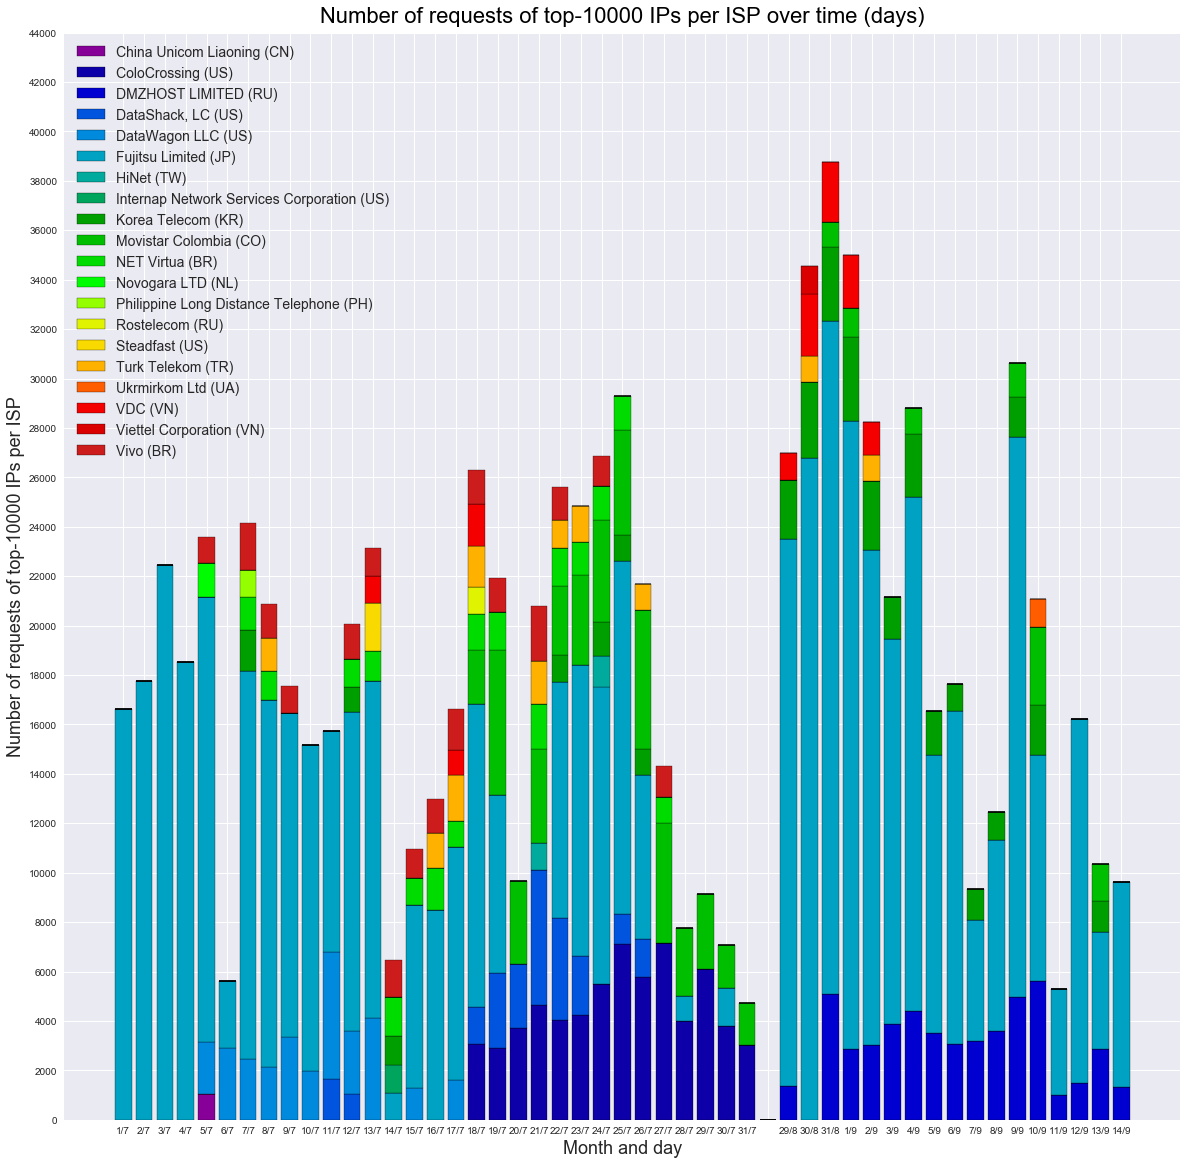

In [9]:
utilities.show_stacked_bar_figure(isps_dataset_1a, xaxis, 0.8, 'Number of requests of top-10000 IPs per ISP over time (days)', 'Month and day', 'Number of requests of top-10000 IPs per ISP', "1a", max(day_totals_1a) + 7000, 2000)

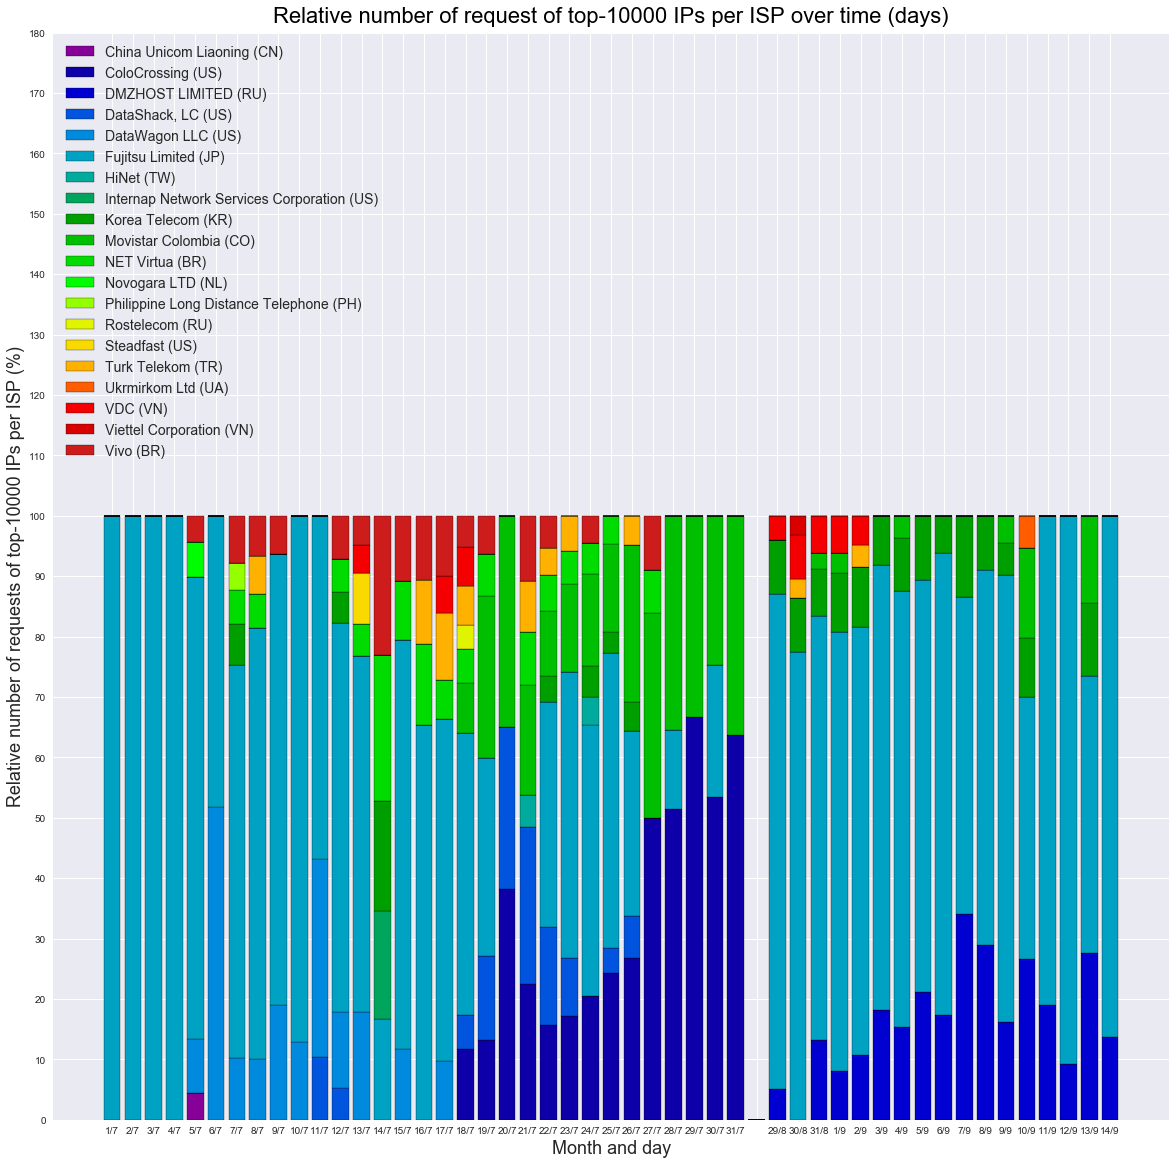

In [10]:
utilities.show_stacked_bar_figure(isps_dataset_normal_1a, xaxis, 0.8, 'Relative number of request of top-10000 IPs per ISP over time (days)', 'Month and day', 'Relative number of requests of top-10000 IPs per ISP (%)', "1a_normalized", 190, 10)

### 1b - Unique top-10000 malicious devices per ISP over time
#### 1b.a - Create and store the evaluation

In [11]:
panda_data_1b_agg = panda_data_1a.groupby(['Timestamp', 'isp', 'country', 'countryCode']).size().reset_index()
panda_data_1b_agg.rename(columns={0: 'Unique'}, inplace=True)

panda_data_1b_agg = panda_data_1b_agg.sort_values(['Timestamp', 'Unique', 'isp'], ascending=[True,False,True]).reset_index(drop=True)
print(panda_data_1b_agg.head(10))

panda_data_1b_agg.to_csv("metrics_evaluation_data/1b.csv", sep='\t', encoding='utf-8')

   Timestamp                                      isp            country  \
0 2016-07-01                       Korea Telecom (KR)  Republic of Korea   
1 2016-07-01                               HiNet (TW)             Taiwan   
2 2016-07-01  Philippine Long Distance Telephone (PH)        Philippines   
3 2016-07-01               China Unicom Liaoning (CN)              China   
4 2016-07-01                    Comcast Business (US)      United States   
5 2016-07-01                        Turk Telekom (TR)             Turkey   
6 2016-07-01                       Comcast Cable (US)      United States   
7 2016-07-01                 China Unicom Shanxi (CN)              China   
8 2016-07-01                          NET Virtua (BR)             Brazil   
9 2016-07-01                        SK Broadband (KR)  Republic of Korea   

  countryCode  Unique  
0          KR      93  
1          TW      26  
2          PH      19  
3          CN      15  
4          US      15  
5          TR      

#### 1b.b - Reduce dataset for creating visualisation

In [12]:
# Throw away days of ISP data where less than min_amount_per_day unique IPs were found
min_unique_per_day = 15
panda_data_1b_filt = panda_data_1b_agg[panda_data_1b_agg['Unique'] >= min_unique_per_day]
panda_data_1b_filt = panda_data_1b_filt.sort_values(['Timestamp', 'country', 'Unique'], ascending=[True,True,False]).reset_index(drop=True)

print(len(panda_data_1b_filt))
print(panda_data_1b_filt.head(10))

388
   Timestamp                                      isp            country  \
0 2016-07-01               China Unicom Liaoning (CN)              China   
1 2016-07-01  Philippine Long Distance Telephone (PH)        Philippines   
2 2016-07-01                       Korea Telecom (KR)  Republic of Korea   
3 2016-07-01                               HiNet (TW)             Taiwan   
4 2016-07-01                    Comcast Business (US)      United States   
5 2016-07-02                        Telenet BVBA (BE)            Belgium   
6 2016-07-02  Philippine Long Distance Telephone (PH)        Philippines   
7 2016-07-02                       Korea Telecom (KR)  Republic of Korea   
8 2016-07-02                        SK Broadband (KR)  Republic of Korea   
9 2016-07-02                               HiNet (TW)             Taiwan   

  countryCode  Unique  
0          CN      15  
1          PH      19  
2          KR      93  
3          TW      26  
4          US      15  
5          BE  

#### 1b.c - Create and show visualisations

In [13]:
# set timestamp as index for easy searching
panda_data_1b_indexed = panda_data_1b_filt.set_index('Timestamp')

# convert data for showing in graph 
isps_dataset_1b, isps_dataset_normal_1b, day_totals_1b = utilities.get_per_day_data_for_graph(panda_data_1b_indexed, all_days, 'isp', 'Unique')
    
# create the actual bar chart
sorted_dataset_1b = sorted(isps_dataset_1b.items(), key=lambda x: x[0])
sorted_dataset_1b_n = sorted(isps_dataset_normal_1b.items(), key=lambda x: x[0])

print("Done.")

Done.


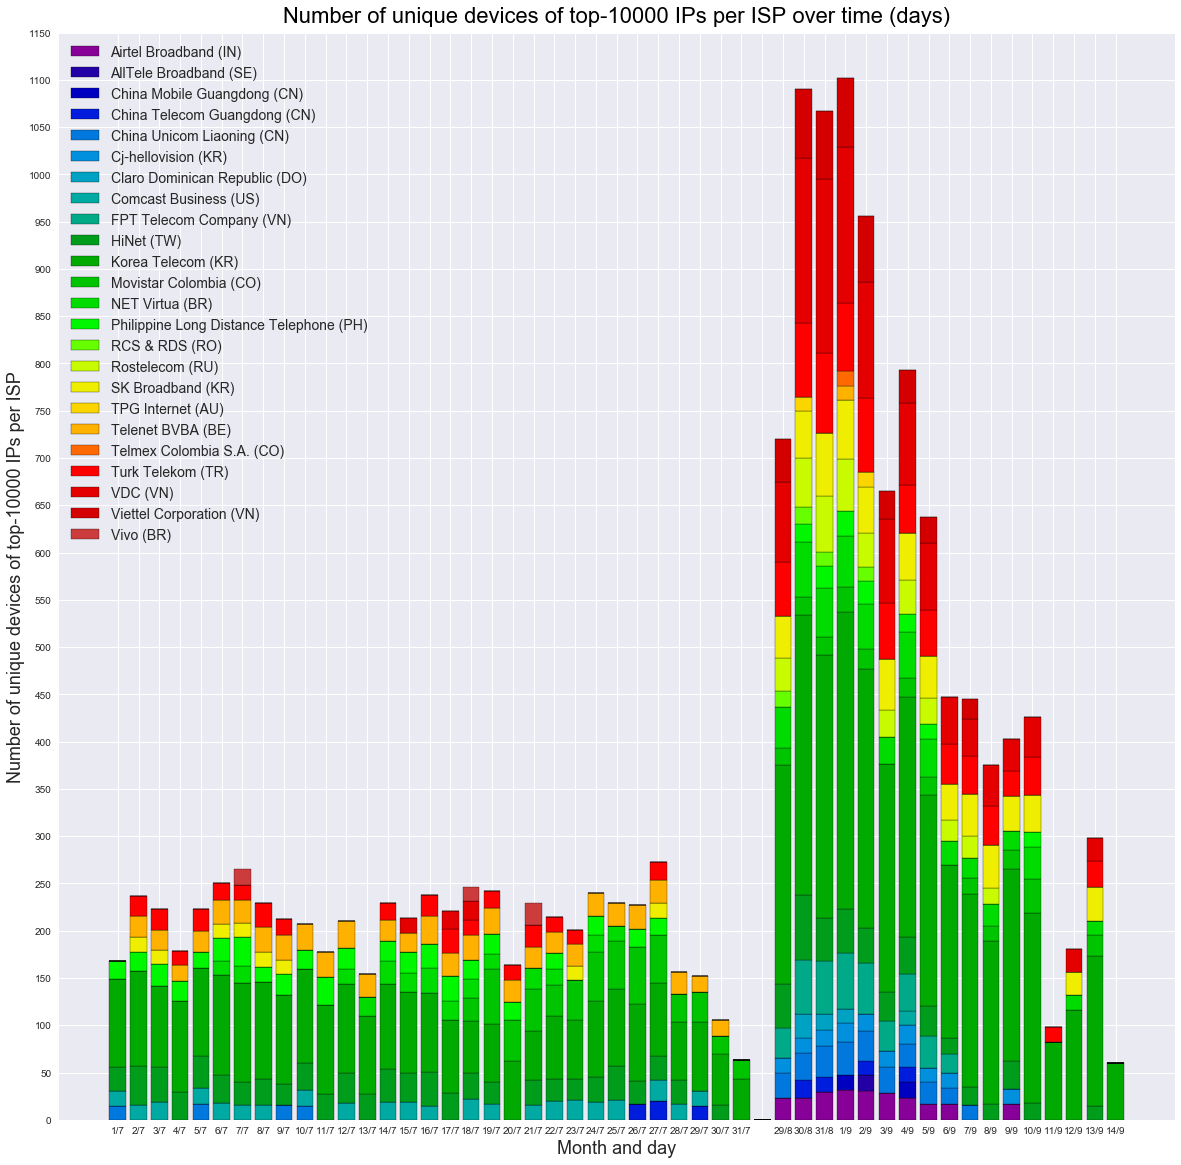

In [14]:
utilities.show_stacked_bar_figure(isps_dataset_1b, xaxis, 0.8, 'Number of unique devices of top-10000 IPs per ISP over time (days)', 'Month and day', 'Number of unique devices of top-10000 IPs per ISP', "1b", 1200, 50)

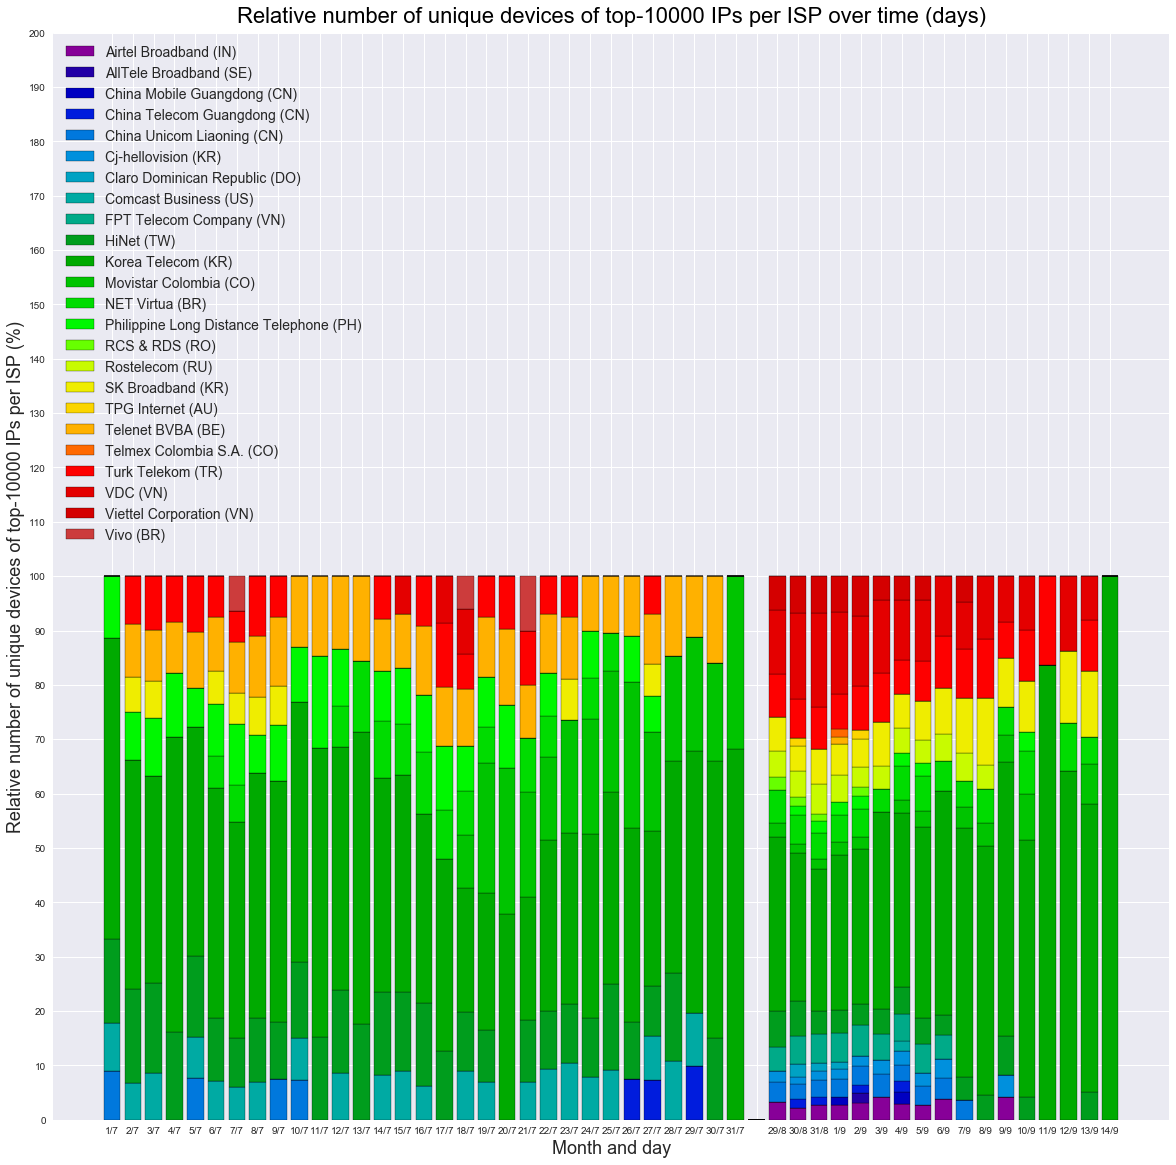

In [15]:
utilities.show_stacked_bar_figure(isps_dataset_normal_1b, xaxis, 0.8, 'Relative number of unique devices of top-10000 IPs per ISP over time (days)', 'Month and day', 'Relative number of unique devices of top-10000 IPs per ISP (%)', "1b_normalized", 210, 10)

### 2a - Total requests per country over time

In [16]:
counter = 0
def get_location_data_2(srcip):  
    #print(srcip)
    global counter
    counter += 1
    if counter % 1000 == 0:
        print(counter)
    return ip_locs_2_new[(ip_locs_2_new.fromIP <= srcip) & (ip_locs_2_new.toIP >= srcip)].iloc[0][['country', 'countryCode']]

def first_x(x):
    return x.head(1)

def last_x(x):
    return x.tail(1)

def repl_to_ip(x):
    #print(x)
    if x['cc_next'] == x['countryCode']:
        return x['ip_next']
    else:
        return x['toIP']

panda_data_2a = panda_data_overtime.copy()

if not os.path.exists("ip_to_countries.csv"):
    
    # load big file and merge countries to make it smaller
    ip_locs_2 = utilities.load_ip_locations("all_ip_locations").reset_index()
    ip_locs_2_new = ip_locs_2[(ip_locs_2["countryCode"] != ip_locs_2["countryCode"].shift()) | (ip_locs_2["countryCode"] != ip_locs_2["countryCode"].shift(-1))][["fromIP","toIP","countryCode","country"]].reset_index(drop=True)
    ip_locs_2_new['cc_next'] = ip_locs_2_new["countryCode"].shift(-1)
    ip_locs_2_new['ip_next'] = ip_locs_2_new["toIP"].shift(-1).str
    ip_locs_2_new = ip_locs_2_new[ip_locs_2_new["countryCode"] != ip_locs_2_new["countryCode"].shift()]
    ip_locs_2_new['toIP'] = ip_locs_2_new.apply(lambda x: repl_to_ip(x), axis=1)
    del ip_locs_2_new['cc_next']
    del ip_locs_2_new['ip_next']
    
    # get country for every IP address in dataset and save file (this takes about 15 minutes..)
    new_ips = panda_data_2a[["SrcIP_I"]].drop_duplicates().sort_values(['SrcIP_I'], ascending=[True]).reset_index(drop=True)
    print(len(new_ips), "\n")
    new_ips[['country', 'countryCode']] = new_ips.apply(lambda x: get_location_data_2(x['SrcIP_I']), axis=1) 
    new_ips= new_ips.set_index("SrcIP_I")
    new_ips.to_csv("ip_to_countries.csv", sep='\t', encoding='utf-8')
    
else:
    new_ips = pd.DataFrame.from_csv("ip_to_countries.csv", sep='\t', encoding='utf-8')

print("Done.")

Done.


In [17]:
total = len(panda_data_2a['SrcIP_I'])
counter_2a = 0
def get_2a_loc_by_ip(ip):
    global counter_2a
    counter_2a += 1
    if counter_2a % 10 == 0:
        utilities.perc_write(counter_2a, total)
    return new_ips.loc[ip]

panda_data_2a[['country', 'countryCode']] = panda_data_2a['SrcIP_I'].apply(lambda x: get_2a_loc_by_ip(x))

print(panda_data_2a.head(10))

----------5----------10
   Timestamp            SrcIP     SrcIP_I  Amount                    country  \
0 2016-07-01   115.177.11.215  1940982743   16618                      Japan   
1 2016-07-01     61.32.10.101  1025509989     129         Korea, Republic of   
2 2016-07-01    91.103.29.251  1533484539     129                    Armenia   
3 2016-07-01    91.234.124.23  1542093847     129                     Poland   
4 2016-07-01  186.124.144.182  3128725686     129                  Argentina   
5 2016-07-01  210.213.207.198  3537227718     129                Philippines   
6 2016-07-01    120.151.90.11  2023184907     128                  Australia   
7 2016-07-01   220.132.91.105  3699661673     126  Taiwan, Province of China   
8 2016-07-01    94.249.112.14  1593405454     125                     Jordan   
9 2016-07-01   189.27.125.175  3172695471     125                     Brazil   

  countryCode  
0          JP  
1          KR  
2          AM  
3          PL  
4          AR  

In [18]:
# group data by country, count unique requests and save dataset
panda_data_2a_agg = panda_data_2a.groupby(['Timestamp', 'country', 'countryCode']).agg({'Amount':sum}).reset_index()
panda_data_2a_agg = panda_data_2a_agg.sort_values(['Timestamp', 'Amount', 'country'], ascending=[True,False,True]).reset_index(drop=True)
panda_data_2a_agg = panda_data_2a_agg[panda_data_2a_agg['country'] != "-"]
panda_data_2a_agg.to_csv("metrics_evaluation_data/2a.csv", sep='\t', encoding='utf-8')

print(panda_data_2a_agg.head(10))

   Timestamp                    country countryCode  Amount
0 2016-07-01                      Japan          JP   16656
1 2016-07-01                      China          CN    3598
2 2016-07-01  Taiwan, Province of China          TW    2333
3 2016-07-01                     Brazil          BR    2197
4 2016-07-01                   Viet Nam          VN    1859
5 2016-07-01              United States          US    1478
6 2016-07-01                     Turkey          TR    1433
7 2016-07-01         Russian Federation          RU    1263
8 2016-07-01                Philippines          PH    1047
9 2016-07-01         Korea, Republic of          KR    1011


In [19]:
# Throw away days of country data where less than min_amount_per_day unique IPs were found
min_amount_per_day_2a = 1500
panda_data_2a_filt = panda_data_2a_agg[panda_data_2a_agg['Amount'] >= min_amount_per_day_2a]
panda_data_2a_filt = panda_data_2a_filt.sort_values(['Timestamp', 'country', 'Amount'], ascending=[True,True,False]).reset_index(drop=True)

print(len(panda_data_2a_filt))
print(panda_data_2a_filt.head(10))

479
   Timestamp                    country countryCode  Amount
0 2016-07-01                     Brazil          BR    2197
1 2016-07-01                      China          CN    3598
2 2016-07-01                      Japan          JP   16656
3 2016-07-01  Taiwan, Province of China          TW    2333
4 2016-07-01                   Viet Nam          VN    1859
5 2016-07-02                     Brazil          BR    3863
6 2016-07-02                      China          CN    4986
7 2016-07-02                      India          IN    1511
8 2016-07-02                      Japan          JP   17820
9 2016-07-02         Russian Federation          RU    1959


In [20]:
# set timestamp as index for easy searching
panda_data_2a_indexed = panda_data_2a_filt.set_index('Timestamp')

# convert data for showing in graph 
isps_dataset_2a, isps_dataset_normal_2a, day_totals_2a = utilities.get_per_day_data_for_graph(panda_data_2a_indexed, all_days, 'country', 'Amount')
    
# create the actual bar chart
sorted_dataset_2a = sorted(isps_dataset_2a.items(), key=lambda x: x[0])
sorted_dataset_2a_n = sorted(isps_dataset_normal_2a.items(), key=lambda x: x[0])

print("Done.")

Done.


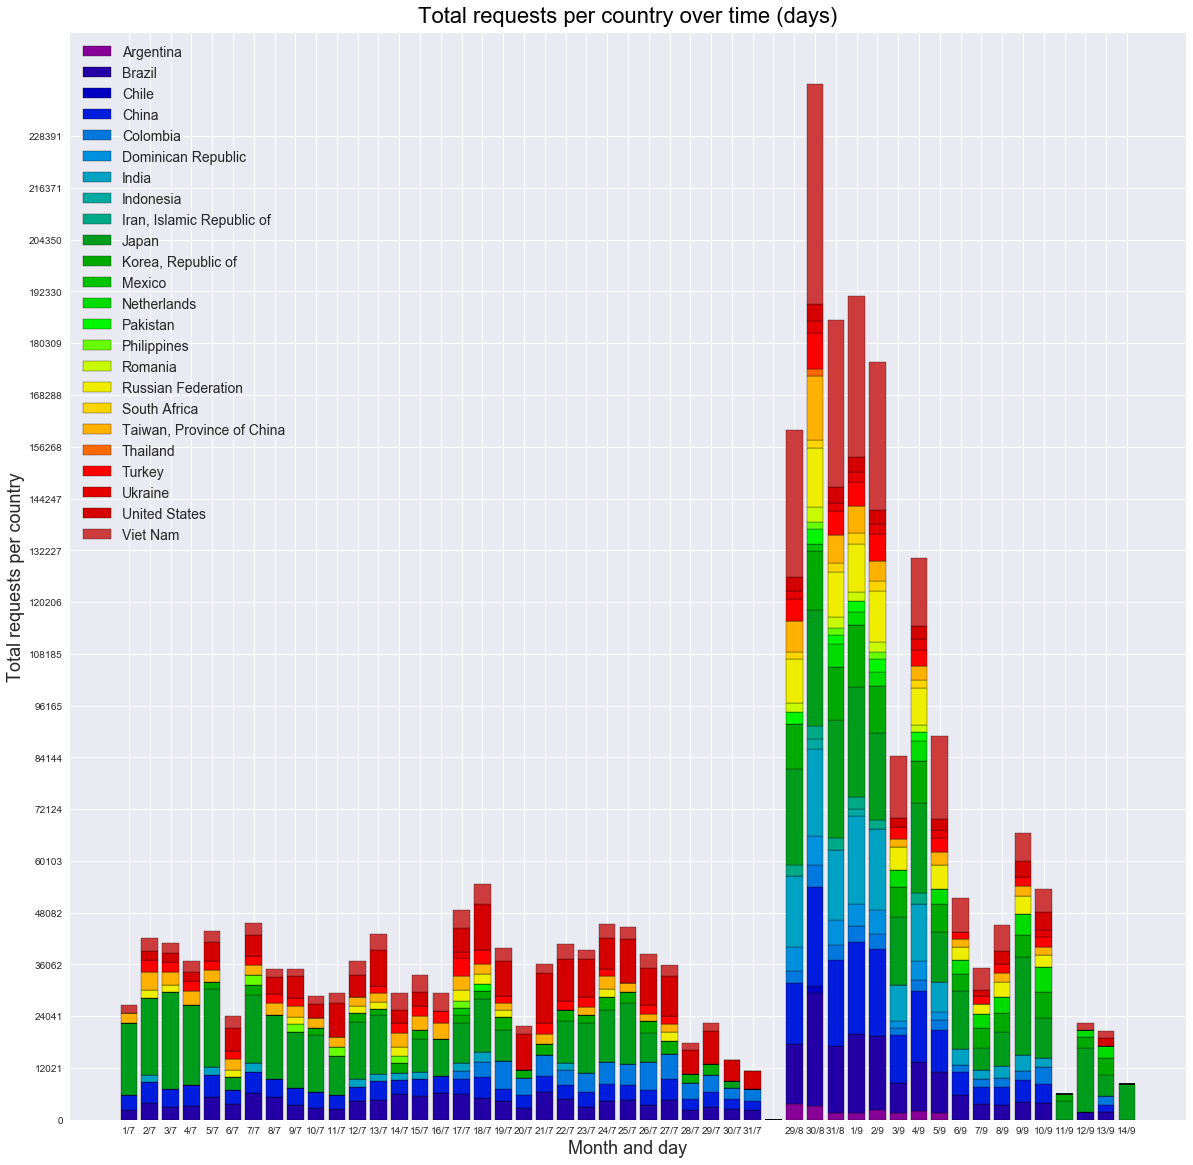

In [21]:
utilities.show_stacked_bar_figure(isps_dataset_2a, xaxis, 0.8, 'Total requests per country over time (days)', 'Month and day', 'Total requests per country', "2a", max(day_totals_2a), max(day_totals_2a) / 20)

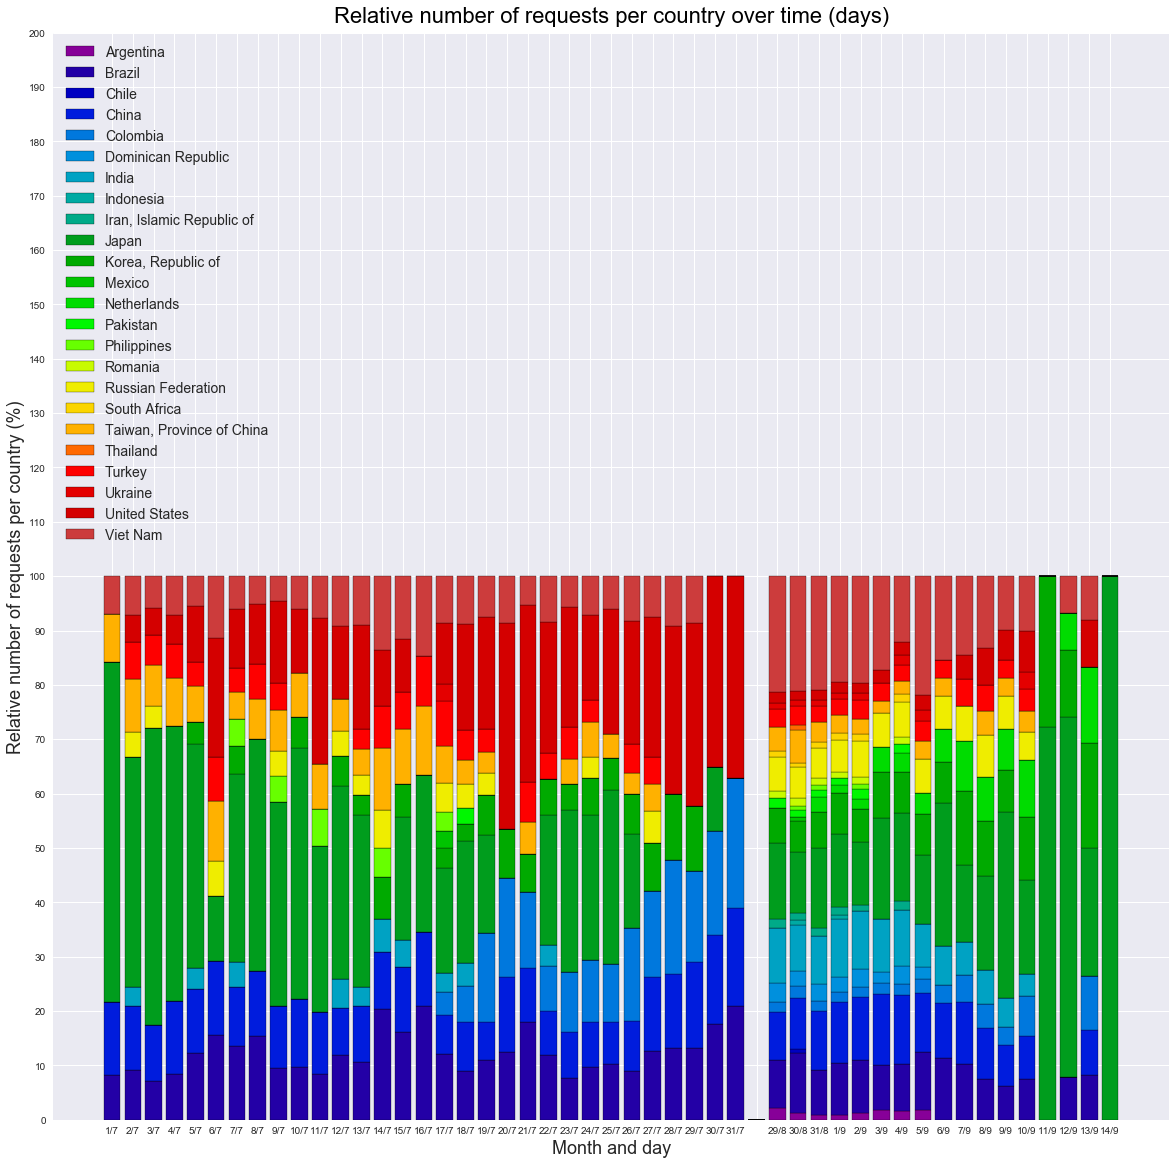

In [22]:
utilities.show_stacked_bar_figure(isps_dataset_normal_2a, xaxis, 0.8, 'Relative number of requests per country over time (days)', 'Month and day', 'Relative number of requests per country (%)', "2a_normalized", 210, 10)

### 2b - Total unique malicious devices per country over time

In [23]:
# group data by country, count unique devices, and save dataset
panda_data_2b_agg = panda_data_2a.groupby(['Timestamp', 'country', 'countryCode']).size().reset_index()
panda_data_2b_agg.rename(columns={0: 'Unique'}, inplace=True)
panda_data_2b_agg = panda_data_2b_agg[panda_data_2b_agg['country'] != "-"]
panda_data_2b_agg = panda_data_2b_agg.sort_values(['Timestamp', 'Unique', 'country'], ascending=[True,False,True]).reset_index(drop=True)
panda_data_2b_agg.to_csv("metrics_evaluation_data/2b.csv", sep='\t', encoding='utf-8')

print(panda_data_2b_agg.head(10))

   Timestamp                    country countryCode  Unique
0 2016-07-01                      China          CN    1810
1 2016-07-01  Taiwan, Province of China          TW    1744
2 2016-07-01                     Brazil          BR    1597
3 2016-07-01                   Viet Nam          VN    1302
4 2016-07-01                     Turkey          TR    1197
5 2016-07-01              United States          US    1055
6 2016-07-01         Russian Federation          RU     807
7 2016-07-01                      India          IN     698
8 2016-07-01                Philippines          PH     635
9 2016-07-01         Korea, Republic of          KR     595


In [24]:
# Throw away days of country data where less than min_amount_per_day unique IPs were found
min_unique_per_day_2b = 500
min_unique_per_day_2b_s = 200
panda_data_2b_filt = panda_data_2b_agg[(panda_data_2b_agg['Unique'] >= min_unique_per_day_2b) | ((panda_data_2b_agg['Timestamp'] >= datetime.date(2016,9,14)) & ((panda_data_2b_agg['Unique'] >= min_unique_per_day_2b_s)))]
panda_data_2b_filt = panda_data_2b_filt.sort_values(['Timestamp', 'country', 'Unique'], ascending=[True,True,False]).reset_index(drop=True)

print(len(panda_data_2b_filt))
print(panda_data_2b_filt.head(10))

475
   Timestamp                    country countryCode  Unique
0 2016-07-01                     Brazil          BR    1597
1 2016-07-01                      China          CN    1810
2 2016-07-01                   Colombia          CO     557
3 2016-07-01                      India          IN     698
4 2016-07-01         Korea, Republic of          KR     595
5 2016-07-01                Philippines          PH     635
6 2016-07-01         Russian Federation          RU     807
7 2016-07-01  Taiwan, Province of China          TW    1744
8 2016-07-01                     Turkey          TR    1197
9 2016-07-01              United States          US    1055


In [25]:
# set timestamp as index for easy searching
panda_data_2b_indexed = panda_data_2b_filt.set_index('Timestamp')

# convert data for showing in graph 
isps_dataset_2b, isps_dataset_normal_2b, day_totals_2b = utilities.get_per_day_data_for_graph(panda_data_2b_indexed, all_days, 'country', 'Unique')
    
# create the actual bar chart
sorted_dataset_2b = sorted(isps_dataset_2b.items(), key=lambda x: x[0])
sorted_dataset_2b_n = sorted(isps_dataset_normal_2b.items(), key=lambda x: x[0])

print("Done.")

Done.


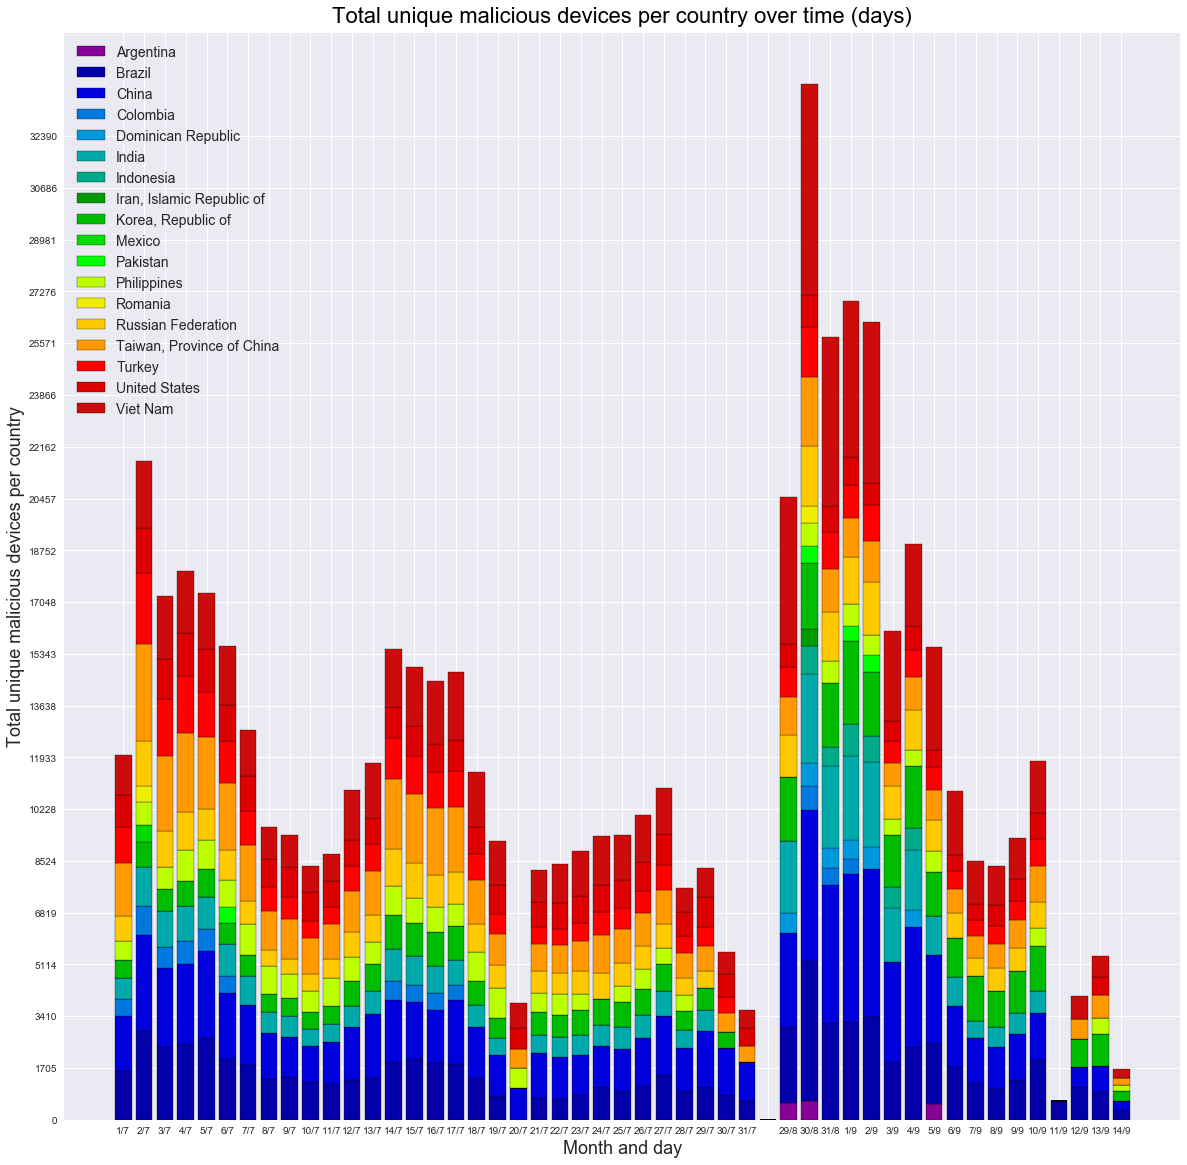

In [26]:
utilities.show_stacked_bar_figure(isps_dataset_2b, xaxis, 0.8, 'Total unique malicious devices per country over time (days)', 'Month and day', 'Total unique malicious devices per country', "2b", max(day_totals_2b), max(day_totals_2b) / 20)

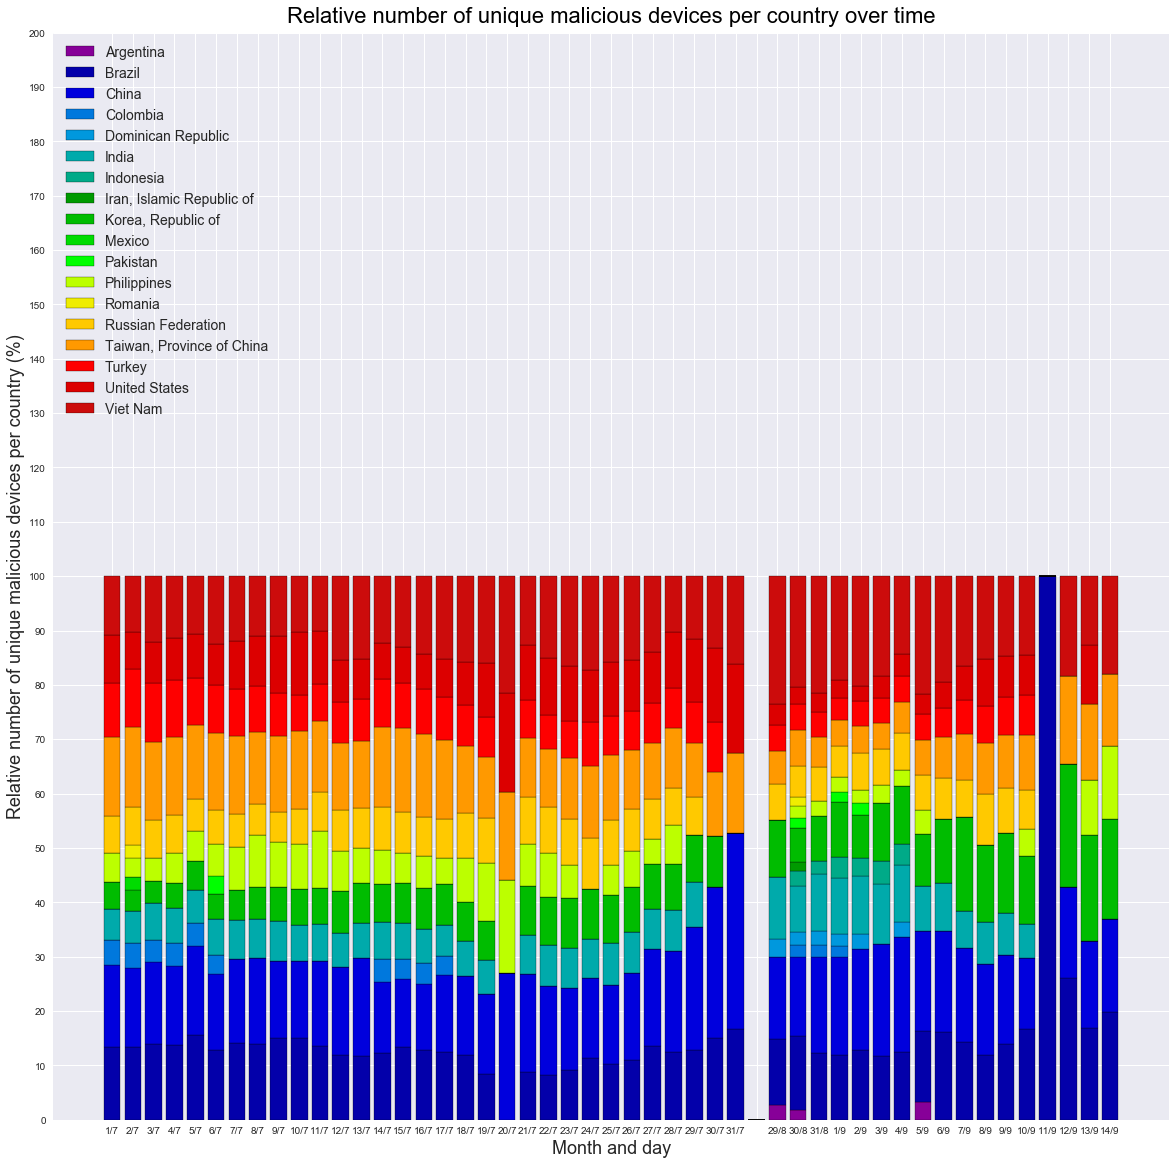

In [27]:
utilities.show_stacked_bar_figure(isps_dataset_normal_2b, xaxis, 0.8, 'Relative number of unique malicious devices per country over time', 'Month and day', 'Relative number of unique malicious devices per country (%)', "2b_normalized", 210, 10)

### 3 - Attack strategy distribution of top-10000 malicious devices per ISP over time

In [28]:
# add attack depth data to every row
panda_data_3 = panda_data_day[['Timestamp', 'SrcIP', 'DstIP', 'Login', 'Malware']].copy()
panda_data_3['Login'] *= 1
panda_data_3['Malware'] *= 1
panda_data_3['Depth'] = panda_data_3['Login'] * (panda_data_3['Login'] + panda_data_3['Malware'])
del panda_data_3['Login']
del panda_data_3['Malware']

# group by SrcIP & DstIP and count occurences
panda_data_3_agg = panda_data_3.copy()
groupie = panda_data_3.groupby(['SrcIP', 'DstIP'])
panda_data_3_agg = groupie.agg({'Depth':max})
panda_data_3_agg['Count'] = groupie.size()
panda_data_3_agg.reset_index(inplace=True)
panda_data_3_agg = panda_data_3_agg.sort_values(['Count', 'Depth', 'SrcIP'], ascending=[False,False,True]).reset_index(drop=True)

print(panda_data_3_agg.head(10))
print(panda_data_3_agg.tail(10))

             SrcIP           DstIP  Depth   Count
0   115.177.11.215  133.34.157.181      2  294690
1  115.176.182.196  133.34.157.181      2  259241
2   115.29.251.112  133.34.157.145      0    1045
3     104.192.0.20  133.34.157.100      1    1016
4   115.29.251.112   133.34.157.95      0     966
5   115.29.251.112   133.34.157.66      0     909
6   115.29.251.112  133.34.157.116      0     892
7     192.3.106.42  133.34.157.163      2     741
8     192.3.106.42  133.34.157.161      2     740
9     192.3.106.42  133.34.157.171      2     713
                SrcIP           DstIP  Depth  Count
1425917  99.98.160.77  133.34.157.150      0      1
1425918  99.98.160.77  133.34.157.165      0      1
1425919  99.98.160.77  133.34.157.170      0      1
1425920  99.98.160.77   133.34.157.61      0      1
1425921  99.98.160.77   133.34.157.62      0      1
1425922  99.98.160.77   133.34.157.69      0      1
1425923  99.98.160.77   133.34.157.71      0      1
1425924  99.98.160.77   133.34.157

In [29]:
# add number of targets per device column
panda_data_3_agg_2 = panda_data_3_agg.copy()
groupie_2 = panda_data_3_agg_2.groupby(['SrcIP'])
panda_data_3_agg_2 = groupie_2.agg({'Depth':'mean', 'Count':'mean'})
panda_data_3_agg_2['Victims'] = groupie_2.size()
panda_data_3_agg_2.reset_index(inplace=True)
panda_data_3_agg_2 = panda_data_3_agg_2.sort_values(['Count', 'Victims', 'Depth', 'SrcIP'], ascending=[False,False,False,True]).reset_index(drop=True)

print(panda_data_3_agg_2.head(10))
print(panda_data_3_agg_2.tail(10))

             SrcIP     Depth          Count  Victims
0   115.177.11.215  2.000000  294690.000000        1
1  115.176.182.196  2.000000  259241.000000        1
2   115.29.251.112  0.000000     953.000000        4
3     192.3.106.42  0.352941     559.428571      119
4   191.96.249.189  1.916667     427.091667      120
5    62.23.168.212  0.000000     404.000000        1
6     78.190.5.227  2.000000     191.000000        1
7    109.103.1.212  0.000000     190.000000        2
8   116.108.79.114  0.000000     190.000000        1
9    121.72.53.186  0.000000     190.000000        1
               SrcIP  Depth  Count  Victims
562238  99.65.57.218    0.0    1.0        1
562239   99.70.16.46    0.0    1.0        1
562240  99.73.223.24    0.0    1.0        1
562241   99.9.188.20    0.0    1.0        1
562242    99.9.65.79    0.0    1.0        1
562243   99.90.148.5    0.0    1.0        1
562244  99.95.27.225    0.0    1.0        1
562245  99.95.27.226    0.0    1.0        1
562246  99.98.73.210 

In [30]:
# add location data to every known row
panda_data_3_loc = panda_data_3_agg_2.copy()
panda_data_3_loc['isp'] = panda_data_3_loc["SrcIP"].apply(lambda x: get_location_data(x, 'isp')) 
panda_data_3_loc['country'] = panda_data_3_loc["SrcIP"].apply(lambda x: get_location_data(x, 'country')) 
panda_data_3_loc['countryCode'] = panda_data_3_loc["SrcIP"].apply(lambda x: get_location_data(x, 'countryCode')) 

# throw away IPs for which we do not know the ISP (outside top-10000)
panda_data_3_loc = panda_data_3_loc[panda_data_3_loc.isp != "None"]

print(panda_data_3_loc.head(10))
print(panda_data_3_loc.tail(10))

             SrcIP     Depth          Count  Victims  \
0   115.177.11.215  2.000000  294690.000000        1   
1  115.176.182.196  2.000000  259241.000000        1   
2   115.29.251.112  0.000000     953.000000        4   
3     192.3.106.42  0.352941     559.428571      119   
4   191.96.249.189  1.916667     427.091667      120   
5    62.23.168.212  0.000000     404.000000        1   
6     78.190.5.227  2.000000     191.000000        1   
7    109.103.1.212  0.000000     190.000000        2   
8   116.108.79.114  0.000000     190.000000        1   
9    121.72.53.186  0.000000     190.000000        1   

                                           isp        country countryCode  
0                         Fujitsu Limited (JP)          Japan          JP  
1                         Fujitsu Limited (JP)          Japan          JP  
2                    Aliyun Computing Co. (CN)          China          CN  
3                            ColoCrossing (US)  United States          US  
4  

In [31]:
# aggregate by ISP 
panda_data_3_isp_agg = panda_data_3_loc.groupby('isp').agg({'Depth':lambda x: list(x), 'Count':lambda x: list(x), 'Victims':lambda x: list(x)}).reset_index()

print(panda_data_3_isp_agg.head(10))
print(panda_data_3_isp_agg.tail(10))

min_vic_count = 50
deph_dict = {}
count_dict = {}
for index, row in panda_data_3_isp_agg.iterrows():
    if sum(row['Victims']) < min_vic_count:
        continue
    depth = []
    count = []
    for i, item in enumerate(row['Depth']):
        depth += [item]*row['Victims'][i]  
        count += [row['Count'][i]]*row['Victims'][i]  
    depth = np.array(depth.copy())
    count = np.array(count.copy())
    deph_dict[row['isp']] = [np.mean(depth), np.std(depth), np.min(depth), np.max(depth)]
    count_dict[row['isp']] = [np.mean(count), np.std(count), np.min(count), np.max(count)]
    
deph_sorted = sorted(deph_dict.items(), key=lambda x: x[1][0], reverse=True)
count_sorted = sorted(count_dict.items(), key=lambda x: x[1][0], reverse=True)

print(deph_sorted[:10])
print(count_sorted[:10])

                       isp                                              Depth  \
0           012 Smile (IL)  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1       013 NetVision (IL)           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
2   296 BROAD NET Com (JP)                                              [0.0]   
3    2DAY Telecom LLP (KZ)                                              [0.0]   
4         2iC Systems (CA)                                              [0.0]   
5       3BB Broadband (TH)                               [0.0, 0.0, 0.0, 0.0]   
6             3S S.A. (PL)                                              [0.0]   
7       3W Infra B.V. (NL)                                              [0.0]   
8  702 Communications (US)                                    [0.0, 0.0, 0.0]   
9   A D Communication (IN)                                              [0.0]   

                                               Count  \
0  [188.0, 64.0, 10.75, 9.25, 7.5, 5.5, 5.3333333...

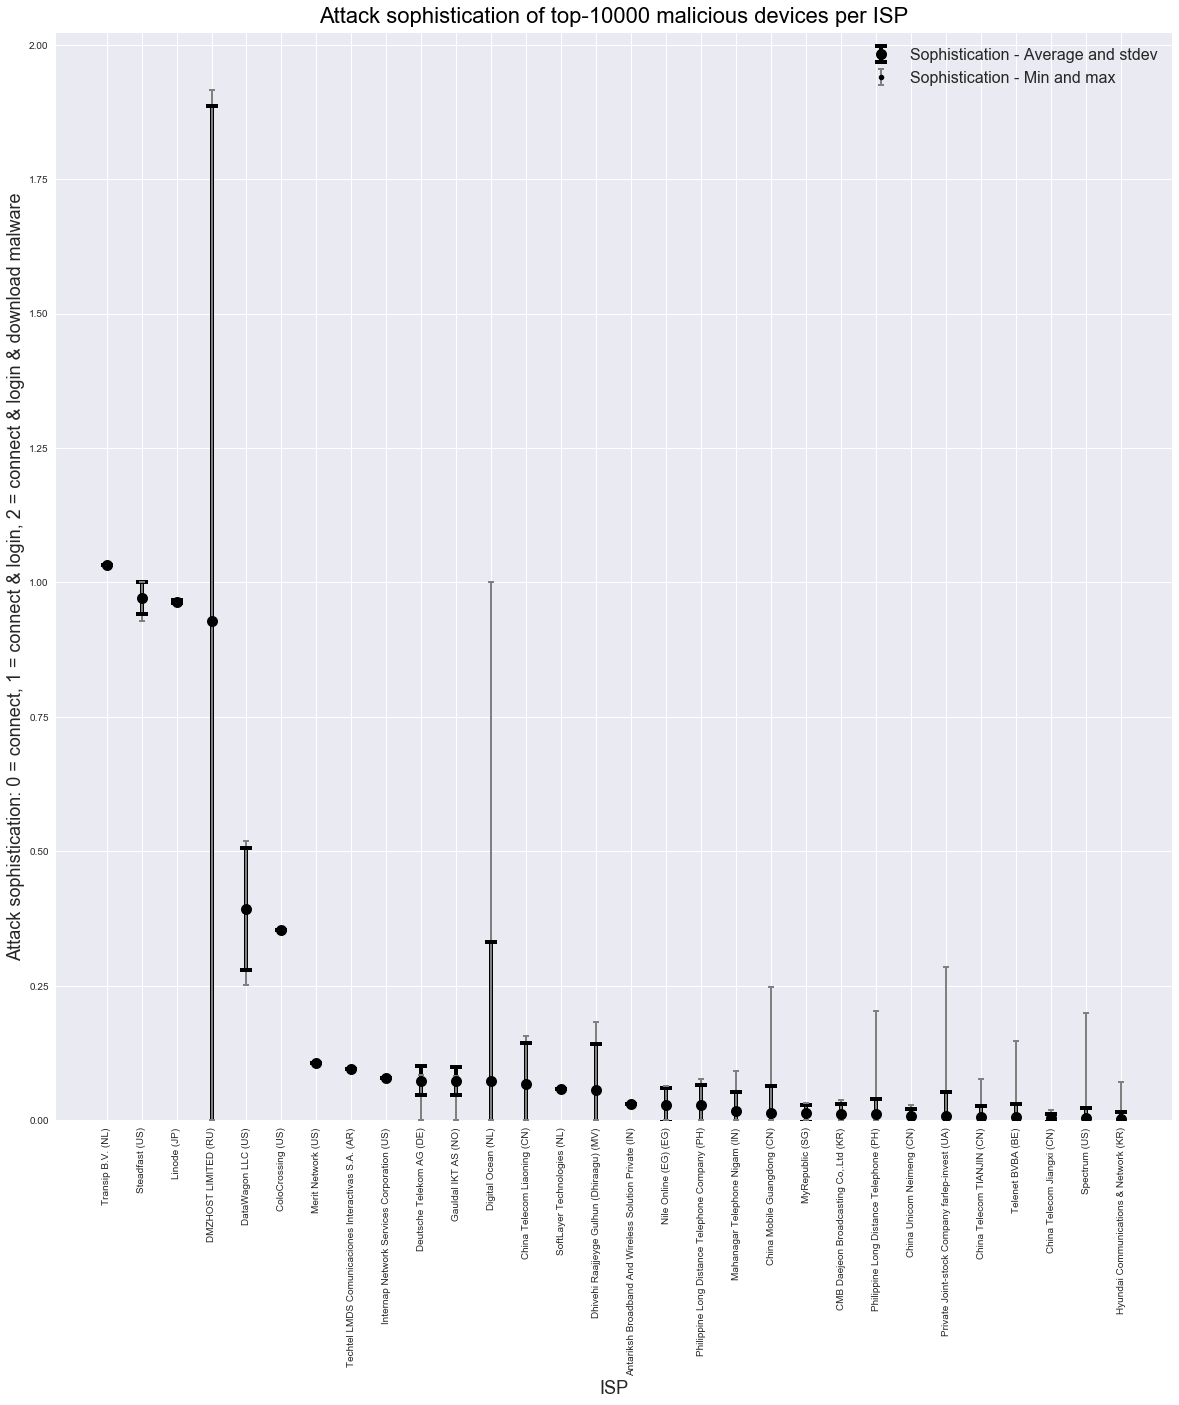

In [32]:
# only use first 30
deph_sorted_f = deph_sorted[:30]

ticks = np.arange(len(deph_sorted_f))
plt.errorbar(ticks, [val[0] for (isp, val) in deph_sorted_f], yerr=[val[1] for (isp, val) in deph_sorted_f], fmt='ok', lw=4, markeredgewidth=4, capsize=6, label='Sophistication - Average and stdev')
plt.errorbar(ticks, [val[0] for (isp, val) in deph_sorted_f], yerr=[[val[0] - val[2] for (isp, val) in deph_sorted_f], [val[3] - val[0] for (isp, val) in deph_sorted_f]], fmt='.k', ecolor='gray', lw=2, markeredgewidth=2, capsize=3, label='Sophistication - Min and max')
ax = plt.gca()
ax.xaxis.set_ticks(ticks)
ax.xaxis.set_ticklabels([isp for (isp, val) in deph_sorted_f], rotation=90)
ax.set_ylim(0, None)

# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'22', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'18'}

# Set the font properties (for use in legend)   
font_path = 'C:\Windows\Fonts\Arial.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=16)

plt.title("Attack sophistication of top-10000 malicious devices per ISP", **title_font)            
plt.xlabel("ISP", **axis_font)
plt.ylabel("Attack sophistication: 0 = connect, 1 = connect & login, 2 = connect & login & download malware", **axis_font)
plt.legend(prop=font_prop, loc='upper right')
plt.savefig('metrics_evaluation_figures/' + "3_sophistication" + '.png', dpi=200, bbox_inches='tight')

plt.show()


In [33]:
print(count_sorted[:30])

[('ColoCrossing (US)', [559.42857142857144, 0.0, 559.42857142857144, 559.42857142857144]), ('DMZHOST LIMITED (RU)', [207.17338709677409, 212.93495857519508, 1.0, 427.09166666666664]), ('DataWagon LLC (US)', [105.43508771929825, 50.400910275044204, 64.014705882352942, 168.53153153153153]), ('DataShack, LC (US)', [45.087603305785123, 4.2057796230466247, 41.084033613445378, 52.844961240310077]), ('Ukrmirkom Ltd (UA)', [39.669230769230772, 0.0, 39.669230769230772, 39.669230769230772]), ('Steadfast (US)', [18.339622641509433, 0.5181189042473523, 17.607142857142858, 18.90909090909091]), ('Novogara LTD (NL)', [12.064516129032256, 16.746636238719297, 1.0, 77.388888888888886]), ('JSC Moldtelecom S.A. (MD)', [11.611111111111111, 18.059565259898786, 3.6875, 76.599999999999994]), ('Moldtelecom SA (MD)', [9.9761904761904781, 10.825235266744155, 3.2727272727272729, 49.333333333333336]), ('Polkomtel Sp. z o.o. (PL)', [9.7517241379310349, 29.862692913765009, 1.0, 142.0]), ('Telecommunication Services 

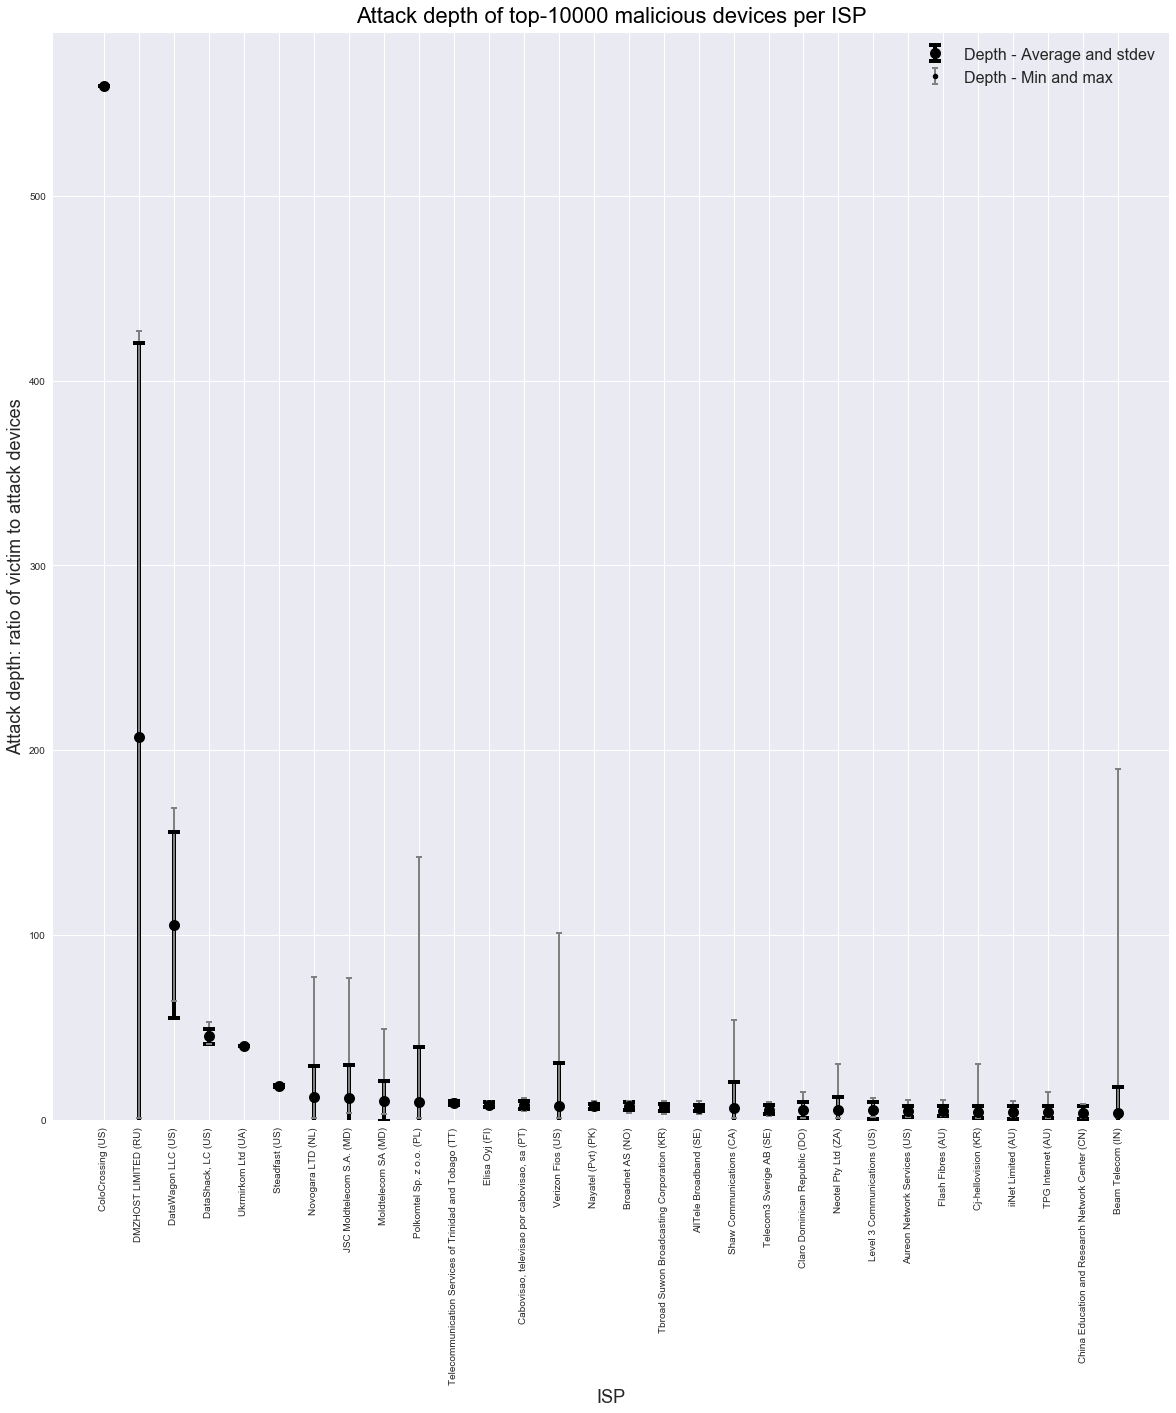

In [38]:
# only use first 30
count_sorted_f = count_sorted[:30]

ticks = np.arange(len(count_sorted_f))
plt.errorbar(ticks, [val[0] for (isp, val) in count_sorted_f], yerr=[val[1] for (isp, val) in count_sorted_f], fmt='ok', lw=4, markeredgewidth=4, capsize=6, label='Depth - Average and stdev')
plt.errorbar(ticks, [val[0] for (isp, val) in count_sorted_f], yerr=[[val[0] - val[2] for (isp, val) in count_sorted_f], [val[3] - val[0] for (isp, val) in count_sorted_f]], fmt='.k', ecolor='gray', lw=2, markeredgewidth=2, capsize=3, label='Depth - Min and max')
ax = plt.gca()
ax.xaxis.set_ticks(ticks)
ax.xaxis.set_ticklabels([isp for (isp, val) in count_sorted_f], rotation=90)
ax.set_ylim(0, None)

plt.title("Attack depth of top-10000 malicious devices per ISP", **title_font)            
plt.xlabel("ISP", **axis_font)
plt.ylabel("Attack depth: ratio of victim to attack devices", **axis_font)
plt.legend(prop=font_prop, loc='upper right')
plt.savefig('metrics_evaluation_figures/' + "3_depth" + '.png', dpi=200, bbox_inches='tight')

plt.show()

## Block 4 - factor analysis

In [98]:
# get 1a data and aggregate per ISP (combine days)
panda_data_1a_isp = panda_data_1a_agg.copy()

panda_data_1a_isp = panda_data_1a_isp.groupby(['isp', 'country', 'countryCode']).agg({'Amount':sum}).reset_index()
panda_data_1a_isp = panda_data_1a_isp.sort_values(['Amount', 'isp'], ascending=[False,True]).reset_index(drop=True)
panda_data_1a_isp = panda_data_1a_isp.set_index("isp")

print(len(panda_data_1a_isp), panda_data_1a_isp.head(10))

# load ISP upload speed data
print("Loading isp upload data.. ", end="")
isp_upload = pd.DataFrame.from_csv("isp_upload_speeds.csv", sep='\t', encoding='utf-8')[["isp", "upload"]]
isp_upload = isp_upload.sort_values(['upload', 'isp'], ascending=[False,True]).reset_index(drop=True)
isp_upload = isp_upload.set_index("isp")
print("Done.")

print(isp_upload.head(10))

# inner join 1a and upload speeds (also removes ISPs for which upload speed is unknown)
panda_data_1a_isp_upload = pd.merge(panda_data_1a_isp, isp_upload, left_index=True, right_index=True, how='inner');
#panda_data_1a_isp_upload = panda_data_1a_isp_upload[panda_data_1a_isp_upload.Amount < 100000]
print(panda_data_1a_isp_upload['Amount'].to_string(index=False))
print(panda_data_1a_isp_upload['upload'].to_string(index=False))
print(pd.DataFrame(panda_data_1a_isp_upload.index.tolist()).to_string(index=False))

1272                                   country countryCode  Amount
isp                                                          
Fujitsu Limited (JP)                Japan          JP  553931
Movistar Colombia (CO)           Colombia          CO   67651
ColoCrossing (US)           United States          US   66572
Korea Telecom (KR)      Republic of Korea          KR   52084
DMZHOST LIMITED (RU)               Russia          RU   51379
NET Virtua (BR)                    Brazil          BR   34995
Vivo (BR)                          Brazil          BR   31710
Turk Telekom (TR)                  Turkey          TR   30501
DataWagon LLC (US)          United States          US   30049
VDC (VN)                          Vietnam          VN   27712
Loading isp upload data.. Done.
                              upload
isp                                 
Viewqwest Pte (SG)            593.43
StarHub Cable Vision (SG)     491.76
Singtel Fibre Broadband (SG)  485.89
MyRepublic (SG)               474.


Pearson correlation: -0.118059281003


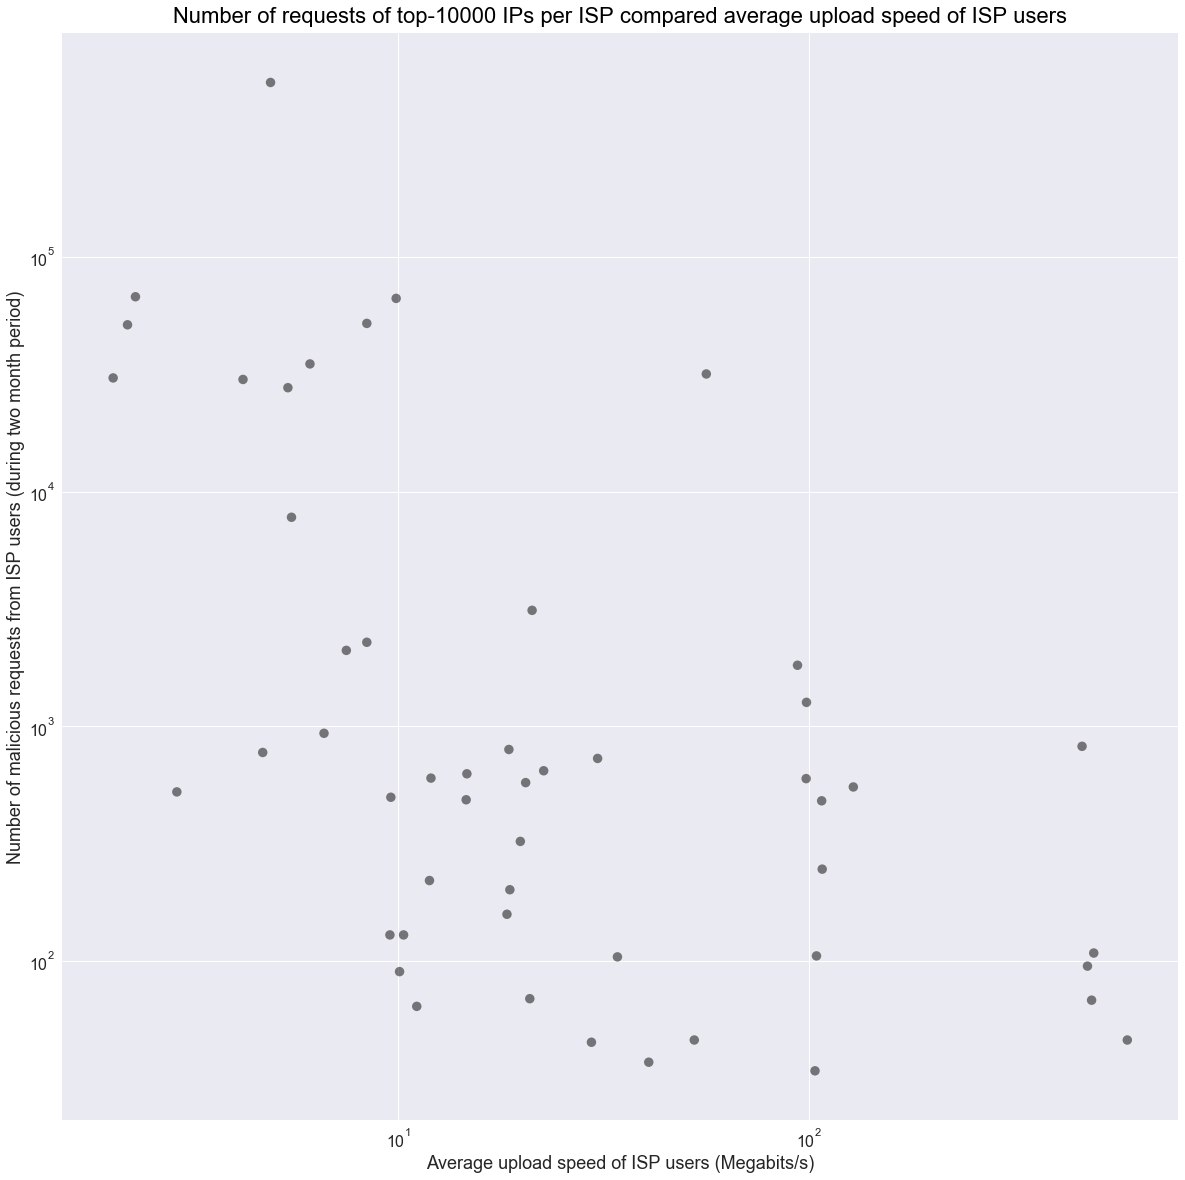

In [81]:
# calculate correlation between ISP requests vs upload speed
pearson = pearsonr(panda_data_1a_isp_upload['upload'], panda_data_1a_isp_upload['Amount'])
print("\nPearson correlation:", pearson[0])

# plot ISP requests vs upload speed
fig = plt.figure()
ax = plt.gca()
ax.scatter(panda_data_1a_isp_upload['upload'], panda_data_1a_isp_upload['Amount'], c='black', s=90, alpha=0.5, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')

# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'22', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'18'}

# Set the font properties (for use in legend)   
font_path = 'C:\Windows\Fonts\Arial.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=14)

plt.tick_params(labelsize=16)
plt.title("Number of requests of top-10000 IPs per ISP compared average upload speed of ISP users", **title_font)            
plt.xlabel("Average upload speed of ISP users (Megabits/s)", **axis_font)
plt.ylabel("Number of malicious requests from ISP users (during two month period)", **axis_font)
plt.grid(True)

plt.savefig('metrics_evaluation_figures/factor_upload_speed.png', dpi=200, bbox_inches='tight')

pylab.show()


# calculate average requests per ISP and lookup global average upload speed 

global_average_upload = 7.2 # Mb/s

# turn ISP requests and upload speed into categorial variables: >= average and < average

# calculate chi square test to see whether the upload speed significantly influences the number of requests (check that every option has at least 5 ISPs or else use Fisher’s exact test)

# done!


In [103]:
panda_data_1a_country = panda_data_1a_isp.groupby(['country', 'countryCode']).agg({'Amount':sum}).reset_index()
panda_data_1a_country = panda_data_1a_country.sort_values(['Amount', 'country'], ascending=[False,True]).reset_index(drop=True)
panda_data_1a_country = panda_data_1a_country.set_index("country")
print(len(panda_data_1a_country), panda_data_1a_country.head(10))

129                   countryCode  Amount
country                              
Japan                      JP  555591
United States              US  162129
Brazil                     BR   90867
Colombia                   CO   82433
Republic of Korea          KR   81698
Russia                     RU   79965
China                      CN   74676
Vietnam                    VN   61118
Turkey                     TR   38141
Taiwan                     TW   28703


In [130]:
# load city distance to to tokyo (Japan) data
print("Loading city distance data.. ", end="")
city_distance = pd.DataFrame.from_csv("country_ping_distance_to_tokyo.csv", sep=',', encoding='utf-8')
city_distance = city_distance.sort_values(['ping', 'distance'], ascending=[False,False]).reset_index()
#city_distance = city_distance.set_index("country")
print("Done.")

print(city_distance.head(10))

# lookup countries of cities
request = "http://gd.geobytes.com/AutoCompleteCity?callback=&q="
def lookup_country_of_city(city, all_cities=False):
    url = request + city
    response = requests.get(url).json()
    if len(response[0]) > 1:
        if len(response) > 1:
            return response[1].split(", ")[-1]
        else:
            return response[0].split(", ")[-1]
    else:
        return "None"


Loading city distance data.. Done.
            city  distance    ping
0         Riyadh      8702  767.16
1   Johannesburg     13549  424.69
2        Kampala     11533  398.78
3      Cape Town     14743  394.87
4        Nairobi     11261  385.29
5  Dar es Salaam     11396  373.75
6            Fez     11444  371.16
7      Karaganda      5469  359.49
8            Nis      9219  351.42
9  St Petersburg      7599  350.75


In [132]:
city_distance['country'] = city_distance['city'].apply(lambda x: lookup_country_of_city(x))  
city_distance = city_distance[city_distance.country != "None"]
print(city_distance.head(10))

             city  distance    ping        country
0          Riyadh      8702  767.16   Saudi Arabia
1    Johannesburg     13549  424.69   South Africa
2         Kampala     11533  398.78         Uganda
3       Cape Town     14743  394.87   South Africa
4         Nairobi     11261  385.29          Kenya
5   Dar es Salaam     11396  373.75       Tanzania
6             Fez     11444  371.16        Morocco
7       Karaganda      5469  359.49     Kazakhstan
8             Nis      9219  351.42  United States
10     Gothenburg      8550  347.79         Sweden


In [135]:
# aggregate by country, average the ping and distance columns
city_distance_agg = city_distance.groupby(['country']).agg({'distance':'mean', 'ping':'mean'}).reset_index()
city_distance_agg = city_distance_agg.sort_values(['ping', 'distance'], ascending=[False,True]).reset_index(drop=True)
city_distance_agg = city_distance_agg.set_index("country")
print(len(city_distance_agg), city_distance_agg.head(10))

# combine with metric 1a results
panda_data_1a_country_ping = pd.merge(panda_data_1a_country, city_distance_agg, left_index=True, right_index=True, how='inner');
print(panda_data_1a_country_ping.head(10))
#print(panda_data_1a_isp_upload['Amount'].to_string(index=False))
#print(panda_data_1a_isp_upload['upload'].to_string(index=False))
#print(pd.DataFrame(panda_data_1a_isp_upload.index.tolist()).to_string(index=False))

# calculate correlation between request amount and distance/ping
panda_data_1a_country_ping = panda_data_1a_country_ping[panda_data_1a_country_ping.ping < 700]

pearson_ping = pearsonr(panda_data_1a_country_ping['ping'], panda_data_1a_country_ping['Amount'])
print("\nPing Pearson correlation:", pearson_ping[0])

pearson_distance = pearsonr(panda_data_1a_country_ping['distance'], panda_data_1a_country_ping['Amount'])
print("\nDistance Pearson correlation:", pearson_distance[0])

# store dataset
panda_data_1a_country_ping.to_csv("metrics_evaluation_data/amount_to_factors_ping_and_distance.csv", sep='\t', encoding='utf-8')

# done!

78               distance    ping
country                       
Saudi Arabia    8702.0  767.16
South Africa   14146.0  409.78
Uganda         11533.0  398.78
Kenya          11261.0  385.29
Tanzania       11396.0  373.75
Morocco        11444.0  371.16
Kazakhstan      5469.0  359.49
Sweden          8550.0  347.79
Portugal       13480.0  341.16
Barbados        9413.0  340.99
              countryCode  Amount      distance        ping
country                                                    
Japan                  JP  555591    617.000000   15.875000
United States          US  162129   9915.634615  195.618558
Brazil                 BR   90867  17670.000000  284.720000
Colombia               CO   82433  14072.000000  235.700000
Russia                 RU   79965   2918.000000  159.590000
China                  CN   74676   2188.666667  104.556667
Vietnam                VN   61118   4004.500000  123.900000
Turkey                 TR   38141   8996.500000  308.267500
Taiwan                 TW